## Topic 5. Neural Networks
## Other Neural Network Topics


In [1]:
# We start by importing the python libraries required to solve the problems

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy as sp
import pandas as pd

# From sklearn we will use the implementations of the Multi-layer perceptron, and the Boltzmann Machines
from sklearn import cluster
from sklearn.datasets import fetch_mldata
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import binarize
from sklearn.neural_network import BernoulliRBM
from sklearn.datasets.mldata import fetch_mldata

# We will also use different metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn import metrics


# We will also discuss about on the neupy implementation of RBM and the Somoclu 
# implementation of Self-Organizing-Maps
from neupy import algorithms
import somoclu


from IPython.display import display
from IPython.display import Image



# Competitive Learning

 We will consider the use of Neural Vector Quantization. Therefore, we start by illustrating how Image Quantization can be implemented using a clustering algorithm like kmeans. For this introduction we use a modified version of the example presented here: http://scikit-learn.org/stable/auto_examples/cluster/plot_face_compress.html


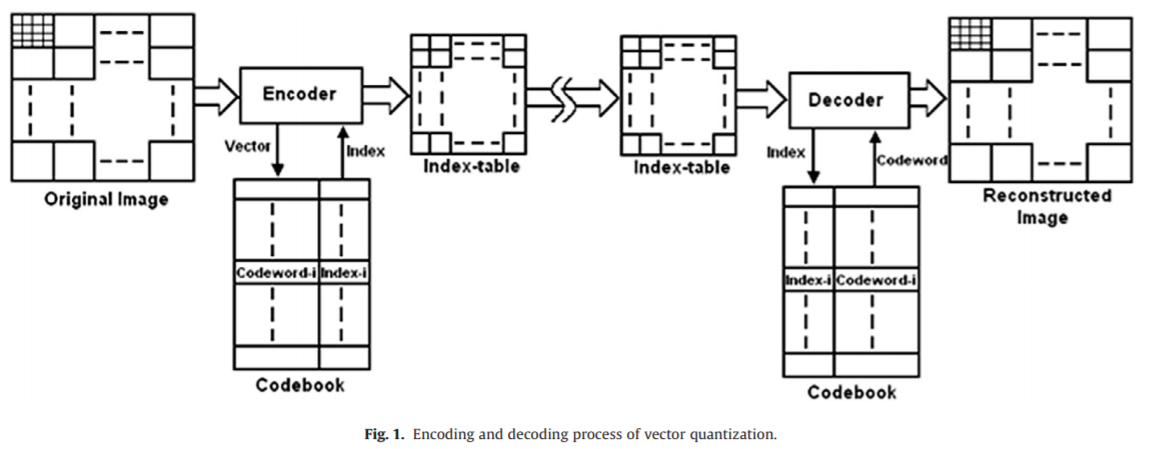

In [2]:
i = Image(filename='images/Image_Quantization.png')
i


The figure above shows a schematic representation of Image Quantization. The goal is to obtain a compressed representation of an image. To do this, a Codebook is created where a number of Codewords or Codevectors are defined together with an index. The Codebook works similarly to a hash table. For each pixel in the image, we look for the corresponding Codeword in the Codebook and USE THE INDEX of the Codeword to represent the pixel. We assume that the number of indices is much smaller than the possible values of a pixel. For example, if we need 8 bits to represent the 256 values of a pixel, we only need 3 bits to represent 8 indices.


The storing cost of the Quantization Mechanism is the number of pixels multiplied by the bits needed to represent an index plus the storing cost of the Codebook.


To decode an image, we simply get the set of indices and recover the corresponding Codewords in the Codebook. Obviously, the selection of good Codewords determines the quality of the Vector Quantization algorithm. 

In the following code, the kmeans algorithm is used to find the Codewords of an image.

We start by reading an image, the "ascent" image. 

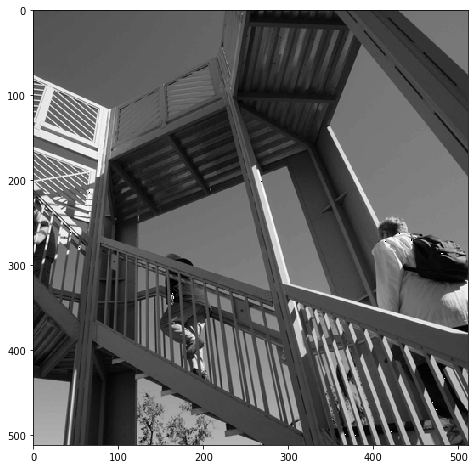

In [3]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# Modified by Roberto Santana
# License: BSD 3 clause

try:  # SciPy >= 0.16 have ascent in misc
    from scipy.misc import ascent  
    ascent = sp.misc.ascent()
except ImportError:
    ascent = sp.ascent()



vmin = ascent.min()
vmax = ascent.max()

# original ascent
plt.figure(1, figsize=(8, 8))
plt.imshow(ascent, cmap=plt.cm.gray, vmin=vmin, vmax=256)
    

## Encoding phase

Using kmeans we cluster ALL THE PIXELS of the image in FIVE CLUSTERs.

In [8]:
ascent

array([[ 83,  83,  83, ..., 117, 117, 117],
       [ 82,  82,  83, ..., 117, 117, 117],
       [ 80,  81,  83, ..., 117, 117, 117],
       ...,
       [178, 178, 178, ...,  57,  59,  57],
       [178, 178, 178, ...,  56,  57,  57],
       [178, 178, 178, ...,  57,  57,  58]])

In [4]:
n_clusters = 5
np.random.seed(0)

X = ascent.reshape((-1, 1))  # We need an (n_sample, n_feature) array
k_means = cluster.KMeans(n_clusters=n_clusters, n_init=4)
k_means.fit(X)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=4, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The variable values contains the centroids of the five clusters (the five Codewords) and labels have for each pixel, its corresponding index. We print all Codevectors and some of the pixel indices.

In [5]:
values = k_means.cluster_centers_.squeeze()
labels = k_means.labels_
print(values)
print(labels[:20000:1000])

[127.33193545  62.51254379 199.84608461  91.34660051  28.48289798]
[3 0 0 0 1 1 1 4 4 4 4 4 3 3 3 3 3 3 3 3]


## Decoding phase

Using the Codebook (values) and the labels, we reconstruct the image.

In [6]:
# create an array from labels and values
ascent_compressed = np.choose(labels, values)
ascent_compressed.shape = ascent.shape

Finally, we print the original image and the one that was quantized. Notice that although there is some deterioration of the image quality, it can be recognized and many details are not lost.

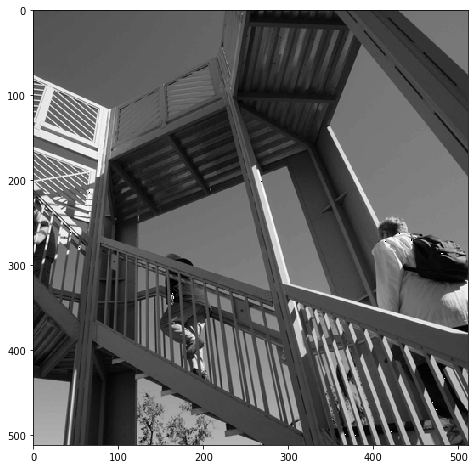

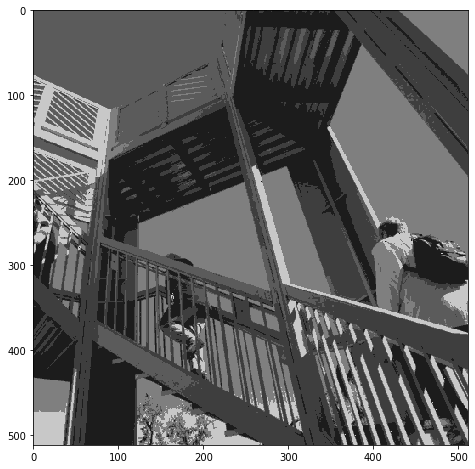

In [7]:
vmin = ascent.min()
vmax = ascent.max()

# original ascent
plt.figure(1, figsize=(8, 8))
plt.imshow(ascent, cmap=plt.cm.gray, vmin=vmin, vmax=256)

# compressed ascent
plt.figure(2, figsize=(8, 8))
plt.imshow(ascent_compressed, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)


plt.show()

## Neural quantization

Now, we will use a Vector Quantization approach to learn a quantization of the image. Vector quantization is Competitive Learning approach where k neurons compete for representing the input data. In the network topology, each of the k neurons is connected to all the inputs by a weight vector. 

Every time an input is presented to the network, all neurons compute their distance to the input, and the neuron that is the closest neuron (Best Matching Unit) is selected. This is call the winner, and in this approach the "winner-takes-all", that means that this neuron and only it will update its weight getting closer to the input. 


The following code implements the Vector Quantization approach for finding Codewords. In this application, the neurons will represent the Codebook. The index of each neuron is the index of the Codeword, and the vector of weights is the Codeword. 


Read the comments to the code and execute it.

In [9]:
from scipy.spatial import distance


# The Codebook contains n_codevectors, each of n_features
# All Codewords are randomly generated
def Init_Code_Vectors(n_codevectors,n_features):
    CodeBook = np.random.rand(n_codevectors,n_features)
    return CodeBook


# The Best Matching Unit (BMU) is the Codeword that is closest
# to the instance according to the Euclidean distance
# The algorithm computes the distances for all Codevectors
# and outputs the index, in the Codebook of the BMU
def Find_Best_Matching_Unit(instance,CodeBook):
    n_codevectors = CodeBook.shape[0]
    dist = np.zeros((n_codevectors))
    for i in range(n_codevectors):
        dist[i] = distance.euclidean(instance,CodeBook[i,:])
    BMU = np.argmin(dist)
    return BMU


# This is the most important step of the algorithm
# The weights of the BMU are updated. 
# This is done by moving the BMU in the direction of of the instance
# Notice the similarity with the learning rule used to learn the Perceptron
# as studied in previous lessons
def Update_BMU(BMU_Weights,instance,learning_rate):
    delta_W = (instance - BMU_Weights)
    new_BMU_Weights = BMU_Weights + learning_rate*delta_W
    return new_BMU_Weights


# This is the main implementation of the Vector Quantization algorithm
# It receives a set of instances (training data), the number of CodeVectors
# that we want in the Codebook (the number of neurons). 
# The number of iterations of the algorithm (in each iterations all the instances
# are given to the network as input) and the learning_rate
def Vector_Quantization(instances,n_codevectors,n_epochs,learning_rate):
    n_instances, n_features = instances.shape
    # The Codebook is randomly initialized
    CodeBook = Init_Code_Vectors(n_codevectors,n_features)
    
    # We plot the location of the neurons (defined by their weights)
    Plot_Instances_and_Prototypes(instances,CodeBook)
    Index = np.zeros((n_instances))
    
    # In each iteration, for a given instance, first the BMU is found.
    # That way we obtain the index for that particular instance
    # Then the weight of the BMU is updated
    # At each step we plot the current location of the neurons
    for i in range(n_epochs):
        for j in range(n_instances):  
            BMU_index =  Find_Best_Matching_Unit(instances[j,:],CodeBook)  
            Index[j] = BMU_index
            CodeBook[BMU_index,:]  = Update_BMU(CodeBook[BMU_index,:],instances[j,:],learning_rate)
             
        Plot_Instances_and_Prototypes(instances,CodeBook)
       
    return CodeBook, Index

# Plot the instances as green 'x' and the neurons as blue 'o'
def Plot_Instances_and_Prototypes(inst,prot):
    #fig = plt.figure()
    plt.plot(inst[:,0],inst[:,1],'bs', lw=4)
    plt.plot(prot[:,0],prot[:,1],'ro', lw=4)
    plt.show()



To test our algorithm, we create a set of 20 2-dimensional vectors located in the corners of a square.
Then the Vector Quantization algorithm is invoked to find the Codevector (centers of the clusters) of these data.
Execute the following cell and observe the figures that are produced. 

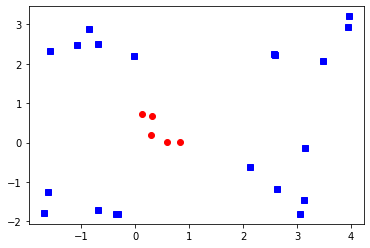

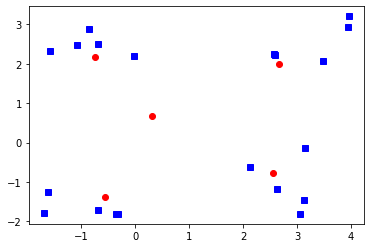

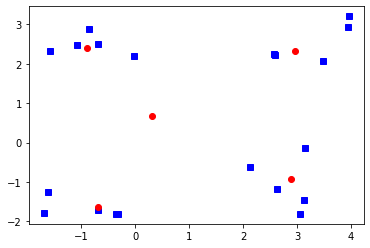

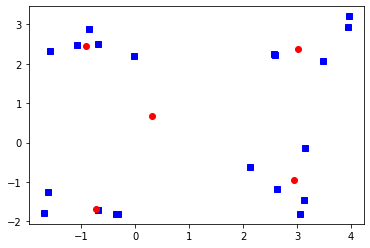

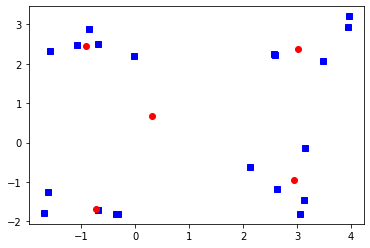

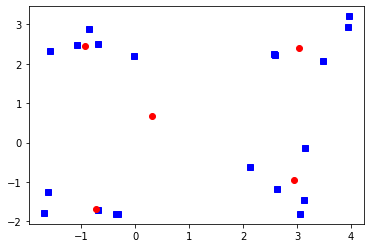

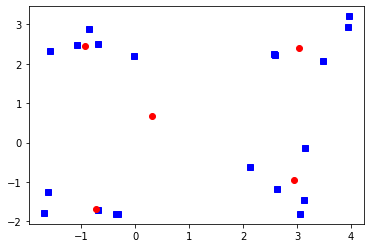

[[ 0.31856895  0.66741038]
 [-0.91689051  2.46231755]
 [-0.72180104 -1.69802658]
 [ 2.95065545 -0.94550643]
 [ 3.02827338  2.39088235]] [1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 4. 4. 4. 4. 4. 3. 3. 3. 3. 3.]


In [10]:
n_prototypes = 5
n_features = 2
n_epochs = 6
learning_rate = 0.3

npoints = 5
left_up =   [-2, 2]+ 2*np.random.rand(npoints,2)
left_down = [-2,-2]+ 2*np.random.rand(npoints,2)
right_up =   [2, 2]+ 2*np.random.rand(npoints,2)
right_down = [2,-2]+ 2*np.random.rand(npoints,2)

instances = np.concatenate([left_up,left_down,right_up,right_down])

CodeBook, Index = Vector_Quantization(instances,n_prototypes,n_epochs,learning_rate)
print(CodeBook,Index)




In [11]:
CodeBook, Index = Vector_Quantization()

TypeError: Vector_Quantization() missing 4 required positional arguments: 'instances', 'n_codevectors', 'n_epochs', and 'learning_rate'